In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import time

In [2]:
df = pd.read_csv(r'C:\Users\Youssef Gaffer\OneDrive\Desktop\imdb_tvshows.csv')

In [3]:
print("Dataset Head:\n", df.head())
print("\nDataset Columns:\n", df.columns)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Head:
                  Title                                              About  \
0       The Family Man  A working man from the National Investigation ...   
1              Lucifer  Lucifer Morningstar has decided he's had enoug...   
2  The Handmaid's Tale  Set in a dystopian future, a woman is forced t...   
3              StartUp  A desperate banker, a Haitian-American gang lo...   
4      Game of Thrones  Nine noble families fight for control over the...   

   EpisodeDuration(in Minutes)                    Genres  \
0                         42.0     Action, Comedy, Drama   
1                         45.0     Crime, Drama, Fantasy   
2                         42.0   Drama, Sci-Fi, Thriller   
3                         60.0           Crime, Thriller   
4                         44.0  Action, Adventure, Drama   

                                              Actors  Rating    Votes  \
0  Manoj Bajpayee, Samantha Akkineni, Priyamani, ...     8.8    57632   
1  Tom Ellis, L

In [4]:
df.rename(columns={
    'Title': 'title',
    'About': 'about',
    'EpisodeDuration(in Minutes)': 'duration',
    'Genres': 'genres',
    'Actors': 'actors',
    'Rating': 'rating',
    'Votes': 'votes',
    'Years': 'years'
}, inplace=True)

In [5]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
        return text.lower()  
    return ''

In [6]:
df['clean_title'] = df['title'].apply(clean_text)
df['clean_about'] = df['about'].apply(clean_text)
df['clean_genres'] = df['genres'].apply(clean_text)
df['clean_actors'] = df['actors'].apply(clean_text)

In [7]:
df['search_text'] = df['clean_title'] + " " + df['clean_about'] + " " + df['clean_genres'] + " " + df['clean_actors']

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]

In [10]:
df['tokens'] = df['search_text'].apply(tokenize_and_remove_stopwords)

In [11]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['search_text'])
feature_names = vectorizer.get_feature_names_out()

In [12]:
def search_movies(query, tfidf_matrix, df):
    query_cleaned = clean_text(query)  
    query_vec = vectorizer.transform([query_cleaned])  
    similarity = cosine_similarity(query_vec, tfidf_matrix)  
    top_indices = similarity[0].argsort()[-10:][::-1]  
    return df.iloc[top_indices][['title', 'genres', 'rating', 'about', 'actors', 'duration', 'votes', 'years']]

In [13]:
query = "science fiction adventure"
start_time = time.time()
results = search_movies(query, tfidf_matrix, df)
end_time = time.time()

In [14]:
print(f"\nSearch Results for Query: '{query}' (Processed in {end_time - start_time:.4f} seconds)")
print(results)


Search Results for Query: 'science fiction adventure' (Processed in 0.0214 seconds)
                         title                         genres  rating  \
2136         Forbidden Science        Drama, Fantasy, Mystery     5.4   
1574    Nangmandakteo Kimsaboo                 Drama, Romance     8.3   
45        Love, Death & Robots       Animation, Short, Comedy     8.5   
635          The Twilight Zone         Drama, Fantasy, Horror     5.8   
1902                Dead Lucky                Crime, Thriller     6.8   
772             Ancient Aliens  Documentary, Fantasy, History     7.2   
1801                 Oogappels                          Drama     8.0   
2635  Shinibsagwan Goohaeryung        Drama, History, Romance     8.2   
1312        Senke nad Balkanom         Crime, Drama, Thriller     9.0   
2727  Fazilet Hanim ve Kizlari                          Drama     6.8   

                                                  about  \
2136  Forbidden Science is a unique blend of noir sc

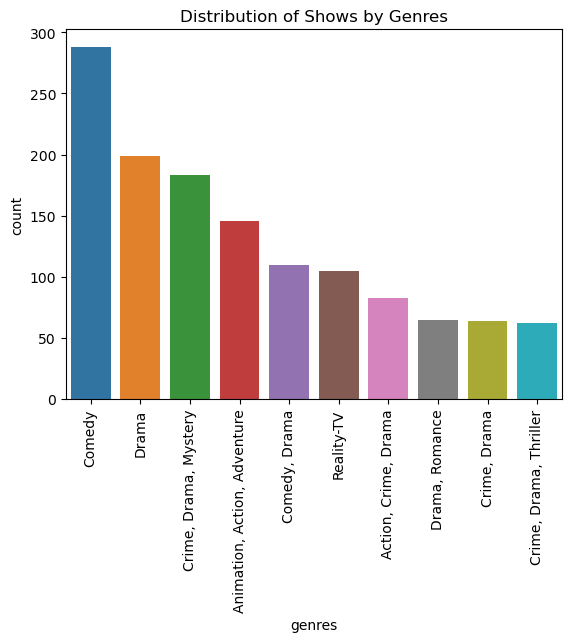

In [21]:
sns.countplot(data=df, x='genres', order=df['genres'].value_counts().index[:10])  
plt.xticks(rotation=90)
plt.title('Distribution of Shows by Genres')
plt.show()

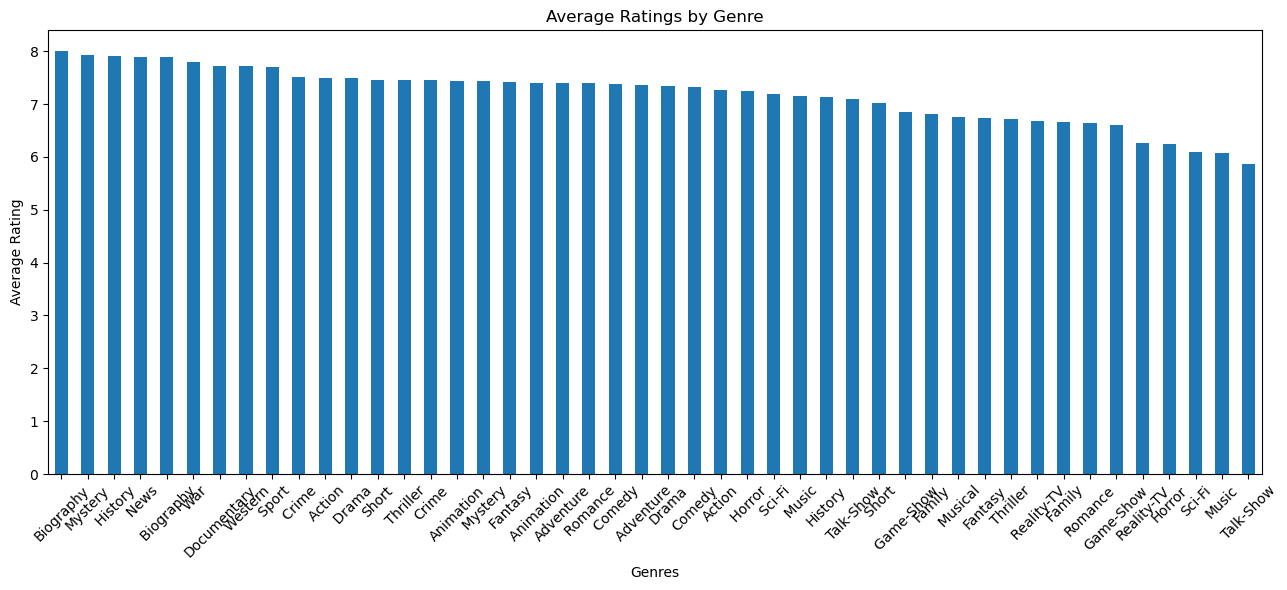

In [22]:
plt.figure(figsize=(13, 6))  
genre_ratings = df.explode('genres_split').groupby('genres_split')['rating'].mean().sort_values(ascending=False)
genre_ratings.plot(kind='bar', title='Average Ratings by Genre')
plt.xlabel('Genres')  
plt.ylabel('Average Rating')  
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()